In [2]:
import pandas as pd

df = pd.read_csv("Merged_Microplastic_Data.csv")

null_counts = df.isnull().sum()
print(null_counts)

Unnamed: 0                                0
DOI                                       0
Sample_ID                                 0
Location                                149
Countries                               149
Source                                    0
Concentration                             6
Concentration_Units                       6
Approximate_Latitude                    155
Approximate_Longitude                   155
Sample_device_and_deployment_methods     21
Digestion                                21
Filtration                               21
Filter_Size                              21
Microplastic_Identification_Method       21
Spectral_Analysis                        21
Controls                                 21
dtype: int64


In [3]:
df = df.dropna(subset=['Concentration', 'Concentration_Units'])

In [4]:
df.columns

Index(['Unnamed: 0', 'DOI', 'Sample_ID', 'Location', 'Countries', 'Source',
       'Concentration', 'Concentration_Units', 'Approximate_Latitude',
       'Approximate_Longitude', 'Sample_device_and_deployment_methods',
       'Digestion', 'Filtration', 'Filter_Size',
       'Microplastic_Identification_Method', 'Spectral_Analysis', 'Controls'],
      dtype='object')

In [5]:
# For Concentration
missing_concentration = df[df['Concentration'].isnull()]
print("Rows with missing Concentration:")
print(missing_concentration)

# For Concentration_Units
missing_units = df[df['Concentration_Units'].isnull()]
print("Rows with missing Concentration_Units:")
[missing_units]

Rows with missing Concentration:
Empty DataFrame
Columns: [Unnamed: 0, DOI, Sample_ID, Location, Countries, Source, Concentration, Concentration_Units, Approximate_Latitude, Approximate_Longitude, Sample_device_and_deployment_methods, Digestion, Filtration, Filter_Size, Microplastic_Identification_Method, Spectral_Analysis, Controls]
Index: []
Rows with missing Concentration_Units:


[Empty DataFrame
 Columns: [Unnamed: 0, DOI, Sample_ID, Location, Countries, Source, Concentration, Concentration_Units, Approximate_Latitude, Approximate_Longitude, Sample_device_and_deployment_methods, Digestion, Filtration, Filter_Size, Microplastic_Identification_Method, Spectral_Analysis, Controls]
 Index: []]

/var/folders/t_/099k0vbd0vnbh2w_3z_42kww0000gp/T/ipykernel_7728/230367228.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Concentration_std'] = df_clean.apply(


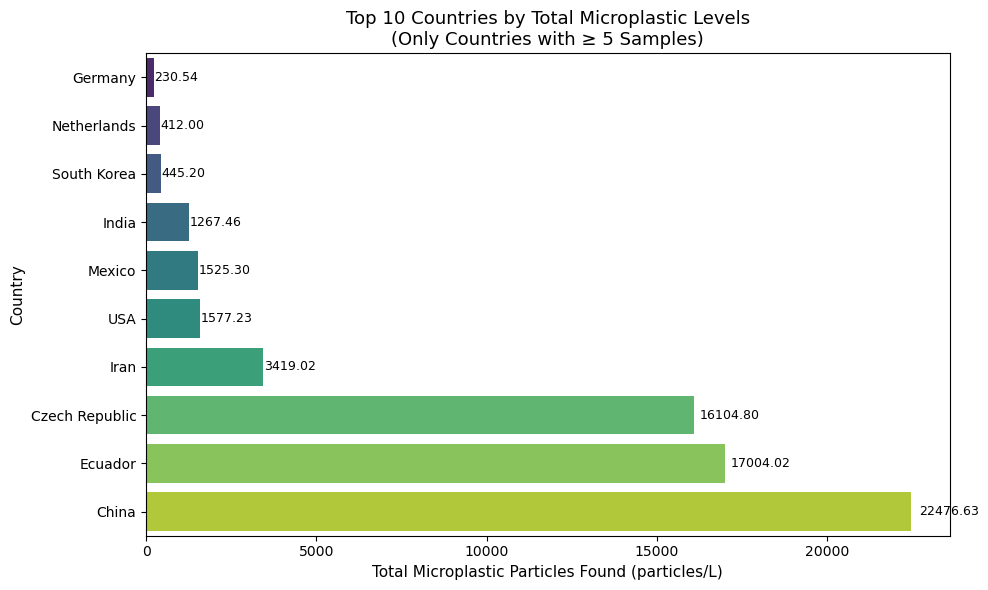

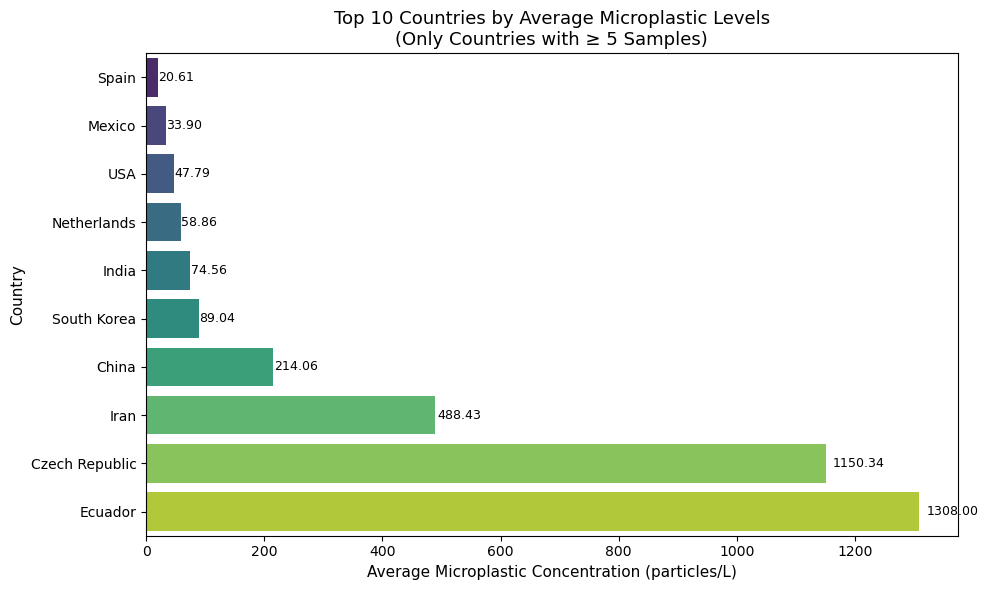

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'Concentration' is numeric
df['Concentration'] = pd.to_numeric(df['Concentration'], errors='coerce')

# Drop rows with missing concentration or unit
df_clean = df.dropna(subset=['Concentration', 'Concentration_Units'])

# Convert units to standardized particles/L
def convert_concentration(value, unit):
    conversion_factors = {
        'particles/L': 1,
        'particles/0.33 L': 1 / 0.33,
        'particles/50 L': 1 / 50,
        'particles/mL': 1000,
        'particles/m3': 1 / 1000
    }
    if np.isnan(value) or unit not in conversion_factors:
        return np.nan
    else:
        return value * conversion_factors[unit]

# Apply conversion
df_clean['Concentration_std'] = df_clean.apply(
    lambda row: convert_concentration(row['Concentration'], row['Concentration_Units']),
    axis=1
)

# Calculate total and average by country (for countries with at least 5 samples)
country_stats = df_clean.groupby('Countries').agg(
    total_std_concentration=('Concentration_std', 'sum'),
    avg_std_concentration=('Concentration_std', 'mean'),
    sample_count=('Concentration_std', 'count')
).reset_index()

country_stats = country_stats[country_stats['sample_count'] >= 5]

# Top 10 by total and average
top10_total = country_stats.sort_values(by='total_std_concentration', ascending=False).head(10)
top10_avg = country_stats.sort_values(by='avg_std_concentration', ascending=False).head(10)

# Sort both for nicer plotting
top10_total = top10_total.sort_values(by='total_std_concentration', ascending=True)
top10_avg = top10_avg.sort_values(by='avg_std_concentration', ascending=True)

# --- PLOT TOTAL ---
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(data=top10_total, x='total_std_concentration', y='Countries', palette='viridis')
plt.xlabel('Total Microplastic Particles Found (particles/L)', fontsize=11)
plt.ylabel('Country', fontsize=11)
plt.title('Top 10 Countries by Total Microplastic Levels\n(Only Countries with ≥ 5 Samples)', fontsize=13)

# Add labels
for patch in ax1.patches:
    width = patch.get_width()
    ax1.text(width + (width * 0.01), 
             patch.get_y() + patch.get_height()/2, 
             f'{width:.2f}', 
             va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

# --- PLOT AVERAGE ---
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(data=top10_avg, x='avg_std_concentration', y='Countries', palette='viridis')
plt.xlabel('Average Microplastic Concentration (particles/L)', fontsize=11)
plt.ylabel('Country', fontsize=11)
plt.title('Top 10 Countries by Average Microplastic Levels\n(Only Countries with ≥ 5 Samples)', fontsize=13)

# Add labels
for patch in ax2.patches:
    width = patch.get_width()
    ax2.text(width + (width * 0.01), 
             patch.get_y() + patch.get_height()/2, 
             f'{width:.2f}', 
             va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

/var/folders/t_/099k0vbd0vnbh2w_3z_42kww0000gp/T/ipykernel_7728/2370062967.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Concentration_std'] = df_clean.apply(


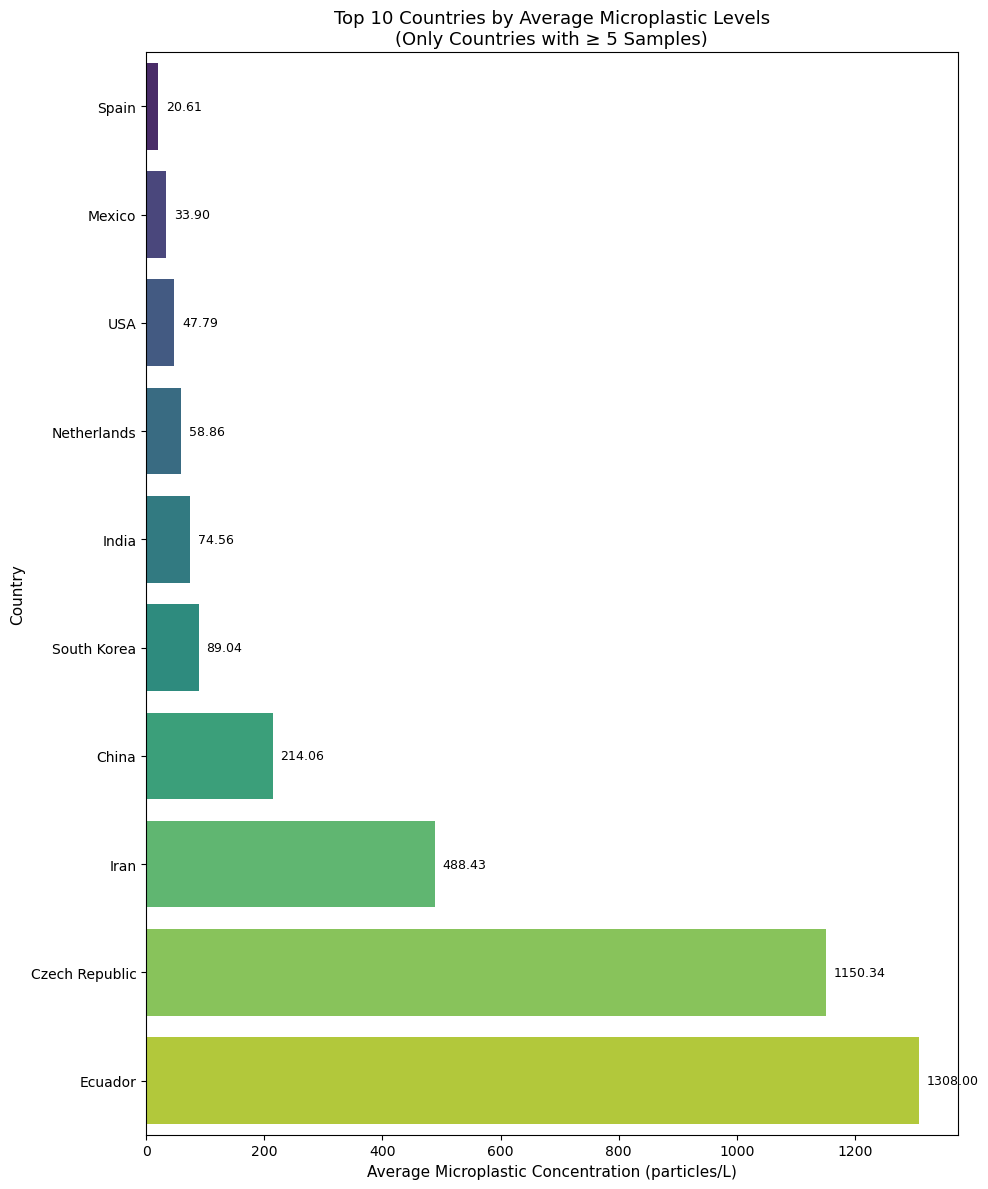

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'Concentration' is numeric
df['Concentration'] = pd.to_numeric(df['Concentration'], errors='coerce')

# Drop rows with missing concentration or unit
df_clean = df.dropna(subset=['Concentration', 'Concentration_Units'])

def convert_concentration(value, unit):
    conversion_factors = {
        'particles/L': 1,
        'particles/0.33 L': 1 / 0.33,
        'particles/50 L': 1 / 50,
        'particles/mL': 1000,
        'particles/m3': 1 / 1000
    }
    if np.isnan(value) or unit not in conversion_factors:
        return np.nan
    else:
        return value * conversion_factors[unit]

# Standardize concentration
df_clean['Concentration_std'] = df_clean.apply(
    lambda row: convert_concentration(row['Concentration'], row['Concentration_Units']),
    axis=1
)

# Group by country and calculate average concentration
country_stats = df_clean.groupby('Countries').agg(
    avg_std_concentration=('Concentration_std', 'mean'),
    sample_count=('Concentration_std', 'count')
).reset_index()

# Filter to countries with at least 5 samples
country_stats = country_stats[country_stats['sample_count'] >= 5]

# Get top 10 countries by average concentration
top10 = country_stats.sort_values(by='avg_std_concentration', ascending=False).head(10)
top10 = top10.sort_values(by='avg_std_concentration', ascending=True).reset_index(drop=True)

# Plot
plt.figure(figsize=(10, 12))
ax = sns.barplot(data=top10, x='avg_std_concentration', y='Countries', palette='viridis')

plt.xlabel('Average Microplastic Concentration (particles/L)', fontsize=11)
plt.ylabel('Country', fontsize=11)
plt.title('Top 10 Countries by Average Microplastic Levels\n(Only Countries with ≥ 5 Samples)', fontsize=13)

# Add labels
max_val = top10['avg_std_concentration'].max()
for patch in ax.patches:
    width = patch.get_width()
    ax.text(width + (max_val * 0.01), 
            patch.get_y() + patch.get_height()/2, 
            f'{width:.2f}', 
            va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

### Count of Sample By Filtration Method  (USA vs Germany)

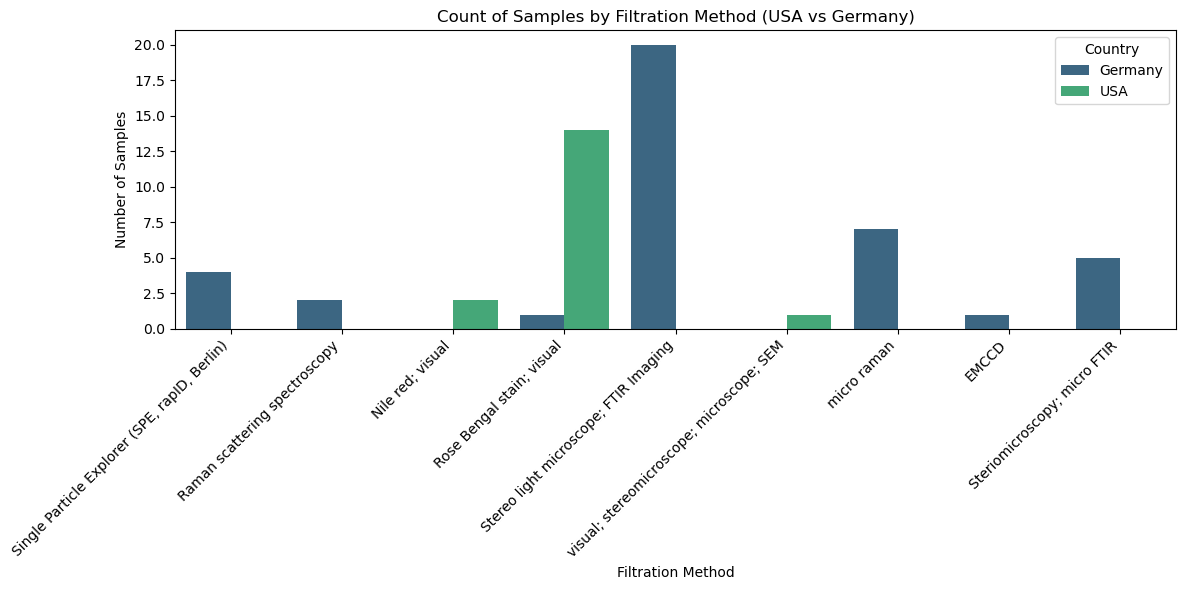

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and clean dataset
df = pd.read_csv("Merged_Microplastic_Data.csv")

# Drop rows where necessary columns are NaN
df = df.dropna(subset=['Microplastic_Identification_Method', 'Countries'])

# Filter the data for USA and Germany
df_filtered = df[df['Countries'].isin(['USA', 'Germany'])]

# Remove rows where the method is "Not Provided"
df_filtered = df_filtered[df_filtered['Microplastic_Identification_Method'] != "Not Provided"]

# Count plot for the number of samples by filtration (identification) method
plt.figure(figsize=(12, 6))
sns.countplot(data=df_filtered, x='Microplastic_Identification_Method', hue='Countries', palette='viridis')

plt.title('Count of Samples by Filtration Method (USA vs Germany)')
plt.xlabel('Filtration Method')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Country')
plt.tight_layout()
plt.show()


### Microplastic Concentration by Filtration Method

In [9]:
df.columns

Index(['Unnamed: 0', 'DOI', 'Sample_ID', 'Location', 'Countries', 'Source',
       'Concentration', 'Concentration_Units', 'Approximate_Latitude',
       'Approximate_Longitude', 'Sample_device_and_deployment_methods',
       'Digestion', 'Filtration', 'Filter_Size',
       'Microplastic_Identification_Method', 'Spectral_Analysis', 'Controls'],
      dtype='object')

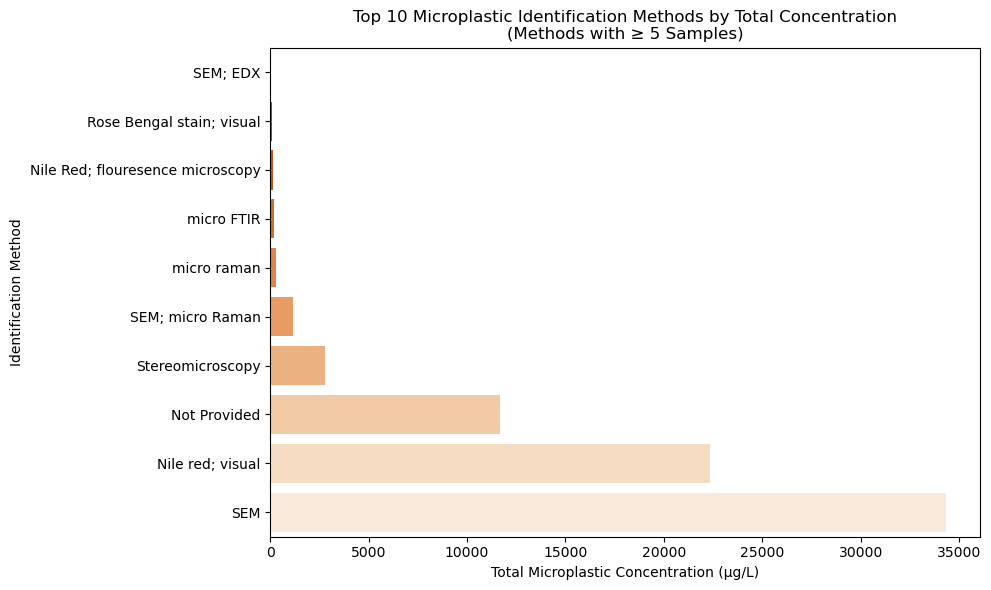

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and clean dataset
df = pd.read_csv("Merged_Microplastic_Data.csv")
df = df[~df['Location'].isnull()]
df = df.dropna(subset=['Approximate_Latitude', 'Approximate_Longitude'])
df = df.copy()
df['Concentration'] = pd.to_numeric(df['Concentration'], errors='coerce')
df = df.dropna(subset=['Concentration'])  # Remove rows where concentration couldn't be converted

# Rename column for clarity
df = df.rename(columns={'Microplastic_Identification_Method': 'Identification_Method'})

# Group by method and calculate total concentration and sample count
method_stats = df.groupby('Identification_Method').agg(
    total_concentration=('Concentration', 'sum'),
    sample_count=('Concentration', 'count')
).reset_index()

# Keep only methods with at least 5 samples
method_stats = method_stats[method_stats['sample_count'] >= 5]

# Sort by total concentration and keep top 10
top10_methods = method_stats.sort_values(by='total_concentration', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10_methods.sort_values(by='total_concentration'),  # sorted for clean display
    x='total_concentration',
    y='Identification_Method',
    palette='Oranges_r'
)
plt.xlabel("Total Microplastic Concentration (µg/L)")
plt.ylabel("Identification Method")
plt.title("Top 10 Microplastic Identification Methods by Total Concentration\n(Methods with ≥ 5 Samples)")
plt.tight_layout()
plt.show()

### Average Microplastic Concentration by Filtration Method  (USA vs Germany)

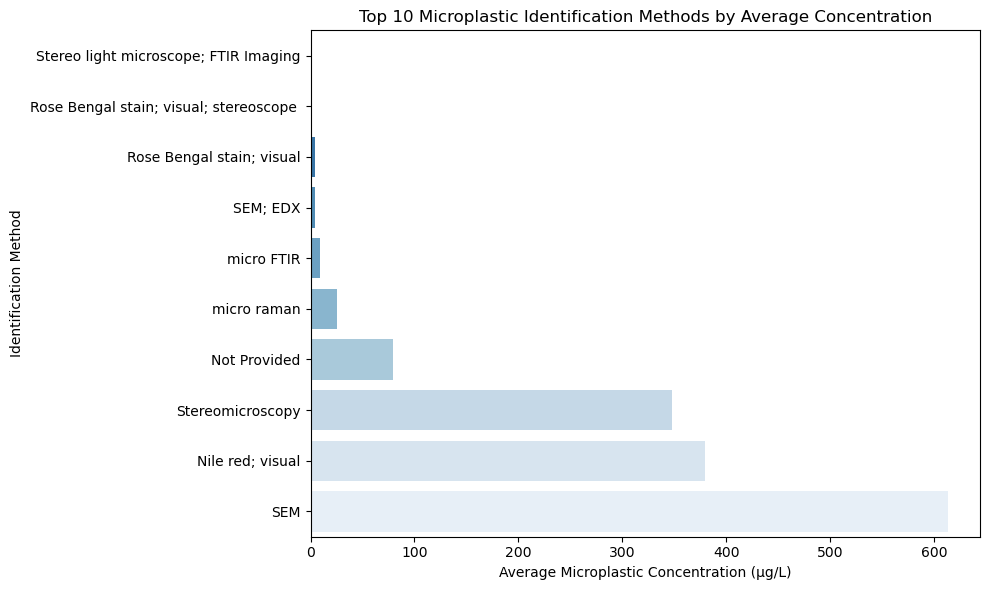

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and clean dataset
df = pd.read_csv("Merged_Microplastic_Data.csv")
df = df[~df['Location'].isnull()]
df = df.dropna(subset=['Approximate_Latitude', 'Approximate_Longitude'])
df = df.copy()
df['Concentration'] = pd.to_numeric(df['Concentration'], errors='coerce')
df = df.dropna(subset=['Concentration'])  # Remove rows where concentration couldn't be converted

# Rename column for clarity if needed (optional)
df = df.rename(columns={'Microplastic_Identification_Method': 'Identification_Method'})

# Get top 10 most common methods
top_methods = df['Identification_Method'].value_counts().head(10).index
filtered_df = df[df['Identification_Method'].isin(top_methods)]

# Group and compute average concentration
mean_conc = filtered_df.groupby('Identification_Method')['Concentration'].mean().sort_values()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_conc.values, y=mean_conc.index, palette='Blues_r')
plt.xlabel("Average Microplastic Concentration (µg/L)")
plt.ylabel("Identification Method")
plt.title("Top 10 Microplastic Identification Methods by Average Concentration")
plt.tight_layout()
plt.show()

### Filtration Method vs. Concentration

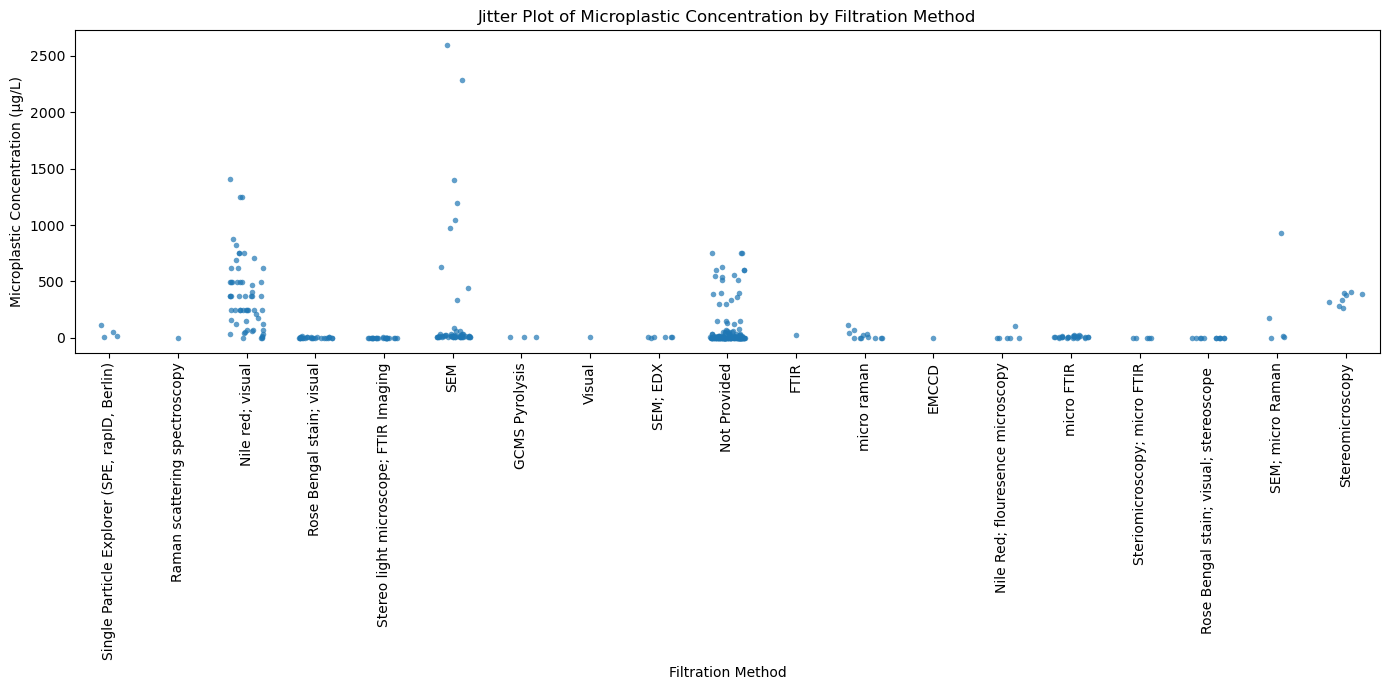

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and clean dataset
df = pd.read_csv("Merged_Microplastic_Data.csv")
df = df[~df['Location'].isnull()]
df = df.dropna(subset=['Approximate_Latitude', 'Approximate_Longitude'])
df = df.copy()
df['Concentration'] = pd.to_numeric(df['Concentration'], errors='coerce')
df = df.dropna(subset=['Concentration'])  # Remove rows where concentration couldn't be converted

# Drop rows without filtration method info
df = df.dropna(subset=['Microplastic_Identification_Method'])

# Filter out extremely high concentrations to reduce skew (optional)
df = df[df['Concentration'] < df['Concentration'].quantile(0.99)]  # Keep bottom 99% only

# Plot
plt.figure(figsize=(14, 7))
sns.stripplot(data=df, x= 'Microplastic_Identification_Method', y='Concentration', jitter=0.25, size=4, alpha=0.7)
plt.xticks(rotation=90)
plt.xlabel("Filtration Method")
plt.ylabel("Microplastic Concentration (µg/L)")
plt.title("Jitter Plot of Microplastic Concentration by Filtration Method")
plt.tight_layout()
plt.show()

 ### Proportion of Effective vs. Ineffective Filters by Country

In [13]:
df.columns

Index(['Unnamed: 0', 'DOI', 'Sample_ID', 'Location', 'Countries', 'Source',
       'Concentration', 'Concentration_Units', 'Approximate_Latitude',
       'Approximate_Longitude', 'Sample_device_and_deployment_methods',
       'Digestion', 'Filtration', 'Filter_Size',
       'Microplastic_Identification_Method', 'Spectral_Analysis', 'Controls'],
      dtype='object')

Unique Countries:
 ['Germany' 'Indonesia' 'India' 'Kenya' 'Mexico' 'USA' 'Brazil' 'Lebanon'
 'Thailand' 'China' 'Cuba' 'Ecuador' 'England' 'France' 'Ireland' 'Italy'
 'Slovakia' 'Switzerland' 'Uganda' 'Belgium' 'Czech Republic' 'Norway'
 'Canada' 'Finland' 'Korea' 'Hong Kong' 'Spain' 'Iran' 'Australia'
 'Denmark' 'Israel' 'Netherlands' 'Poland' 'Russia' 'Scotland'
 'South Korea' 'Sweden' 'Turkey' 'UK']


/var/folders/t_/099k0vbd0vnbh2w_3z_42kww0000gp/T/ipykernel_7728/3790311194.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Effectiveness'] = df_filtered['Concentration'].apply(


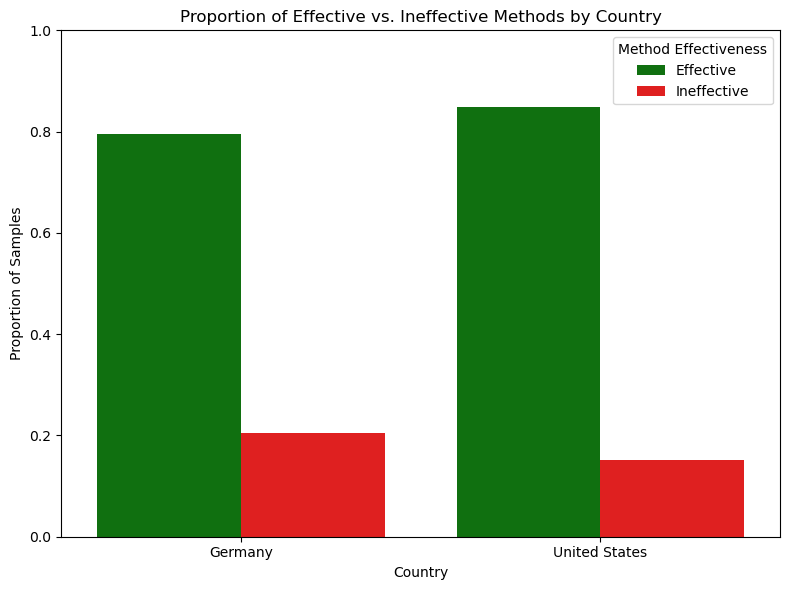

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("Merged_Microplastic_Data.csv")

# Convert 'Concentration' to numeric
df['Concentration'] = pd.to_numeric(df['Concentration'], errors='coerce')

# Drop rows missing either concentration, countries, or identification method
df = df.dropna(subset=['Concentration', 'Countries', 'Microplastic_Identification_Method'])

# Check how country names are spelled
print("Unique Countries:\n", df['Countries'].unique())

# Example: unify 'USA' or 'U.S.A.' with 'United States'
df['Countries'] = df['Countries'].replace({
    'USA': 'United States',
    'U.S.A.': 'United States',
    'United States of America': 'United States'
    # Add other variants if necessary
})

# Filter for Germany and "United States"
df_filtered = df[df['Countries'].isin(['Germany', 'United States'])]

# Define threshold for 'Effective' vs. 'Ineffective'
threshold = 10
df_filtered['Effectiveness'] = df_filtered['Concentration'].apply(
    lambda x: 'Effective' if x < threshold else 'Ineffective'
)

# Group by Country and Effectiveness
summary = df_filtered.groupby(['Countries', 'Effectiveness']).size().unstack(fill_value=0)

# Convert raw counts to proportions
summary_prop = summary.div(summary.sum(axis=1), axis=0).reset_index()

# Reshape for Seaborn (long format)
melted = summary_prop.melt(id_vars='Countries', var_name='Effectiveness', value_name='Proportion')

# Plot side-by-side bar chart
plt.figure(figsize=(8, 6))
sns.barplot(data=melted, x='Countries', y='Proportion', hue='Effectiveness', palette=['green', 'red'])

plt.title('Proportion of Effective vs. Ineffective Methods by Country')
plt.ylabel('Proportion of Samples')
plt.xlabel('Country')
plt.ylim(0, 1)  # Since proportions go from 0 to 1
plt.legend(title='Method Effectiveness')
plt.tight_layout()
plt.show()

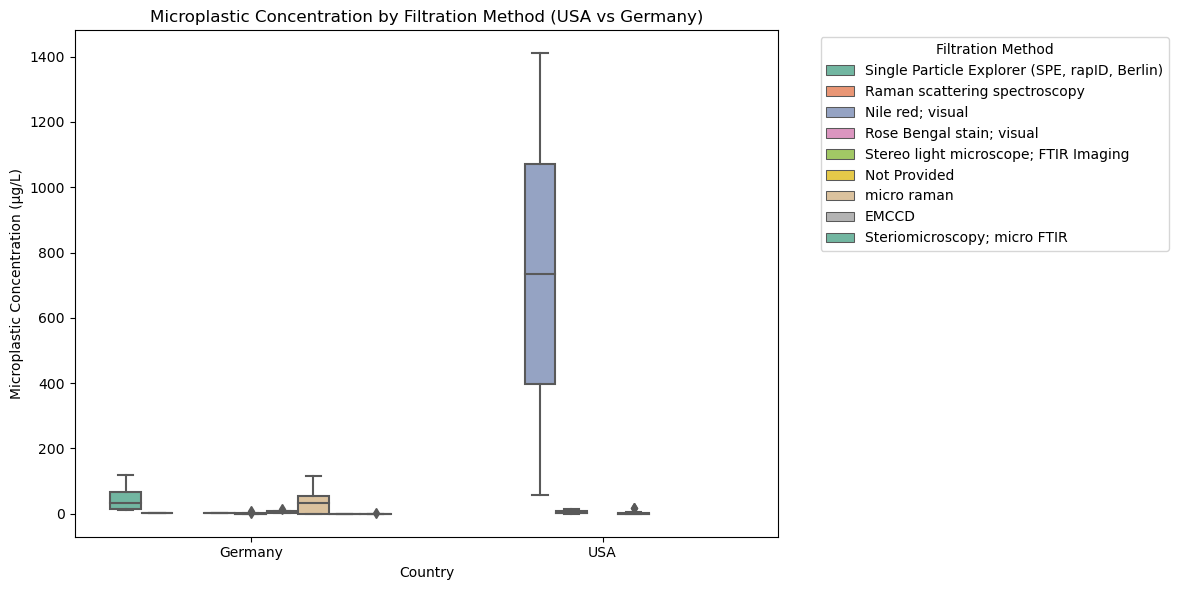

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and clean dataset
df = pd.read_csv("Merged_Microplastic_Data.csv")
df['Concentration'] = pd.to_numeric(df['Concentration'], errors='coerce')
df = df.dropna(subset=['Concentration', 'Countries', 'Microplastic_Identification_Method'])
df = df[df['Countries'].isin(['Germany', 'USA'])]

# Plot boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Countries', y='Concentration', hue='Microplastic_Identification_Method', data=df, palette='Set2')
plt.title('Microplastic Concentration by Filtration Method (USA vs Germany)')
plt.xlabel('Country')
plt.ylabel('Microplastic Concentration (µg/L)')
plt.legend(title='Filtration Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


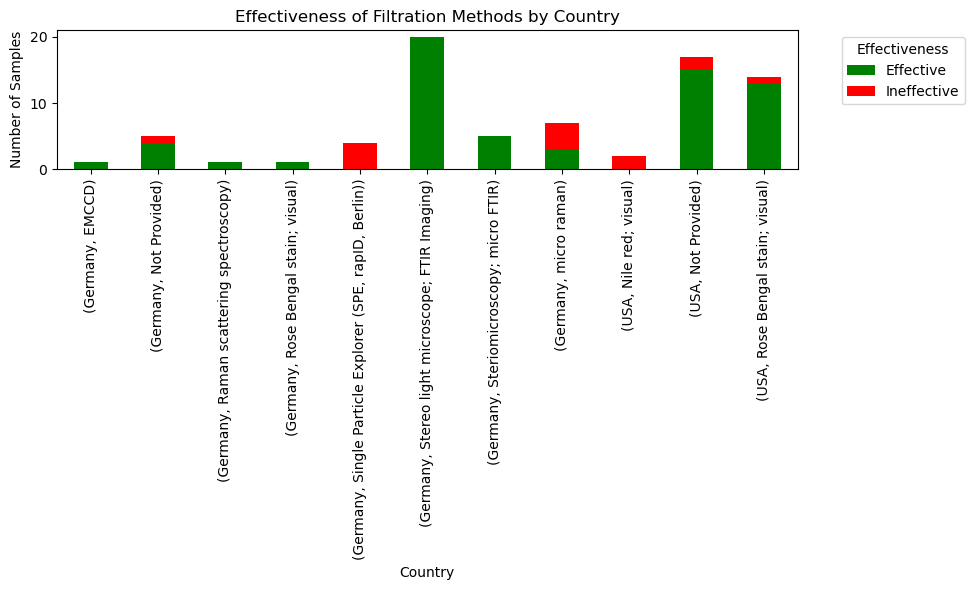

In [16]:
# Define threshold for effectiveness
threshold = 10
df['Effectiveness'] = df['Concentration'].apply(lambda x: 'Effective' if x < threshold else 'Ineffective')

# Group by country and effectiveness
effectiveness_stats = df.groupby(['Countries', 'Microplastic_Identification_Method', 'Effectiveness']).size().unstack(fill_value=0)

# Plot
effectiveness_stats.plot(kind='bar', stacked=True, figsize=(10, 6), color=['green', 'red'])
plt.title('Effectiveness of Filtration Methods by Country')
plt.ylabel('Number of Samples')
plt.xlabel('Country')
plt.legend(title='Effectiveness', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


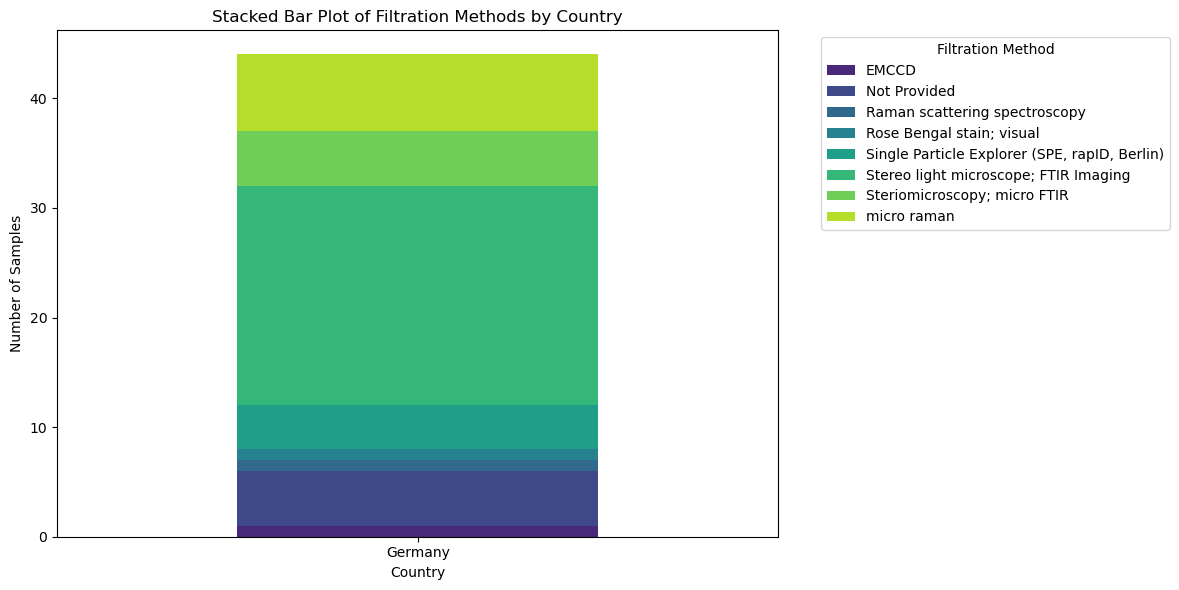

In [17]:
# Stacked bar plot for filtration method counts by country
country_method_counts = df_filtered.groupby(['Countries', 'Microplastic_Identification_Method']).size().unstack()

# Plot
country_method_counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=sns.color_palette('viridis', n_colors=len(country_method_counts.columns)))
plt.title('Stacked Bar Plot of Filtration Methods by Country')
plt.xlabel('Country')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.legend(title='Filtration Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


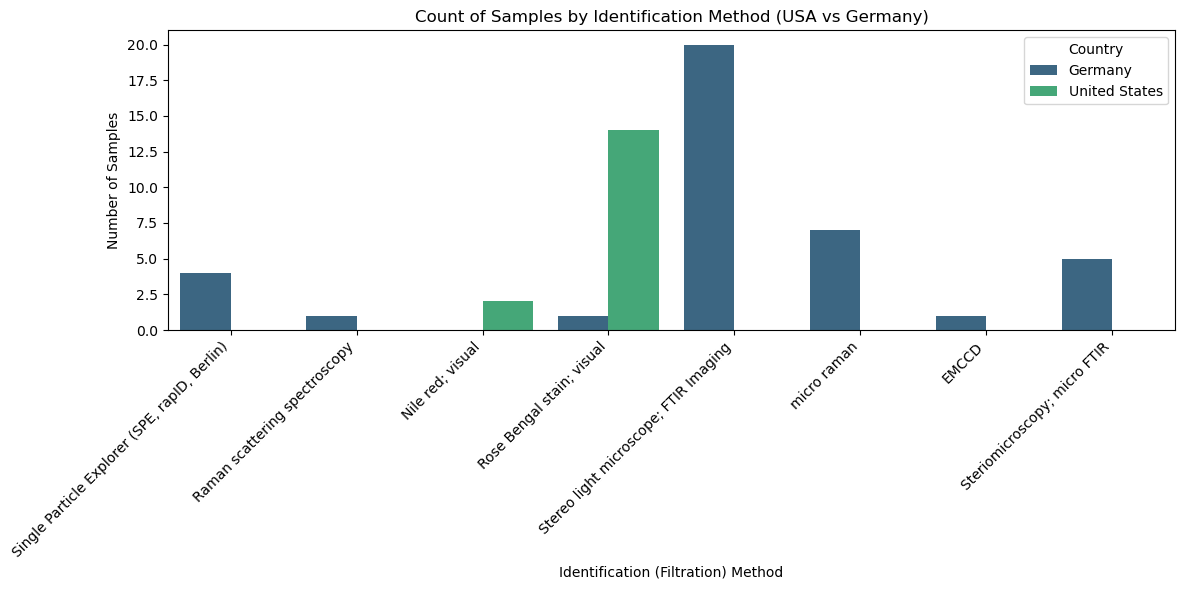

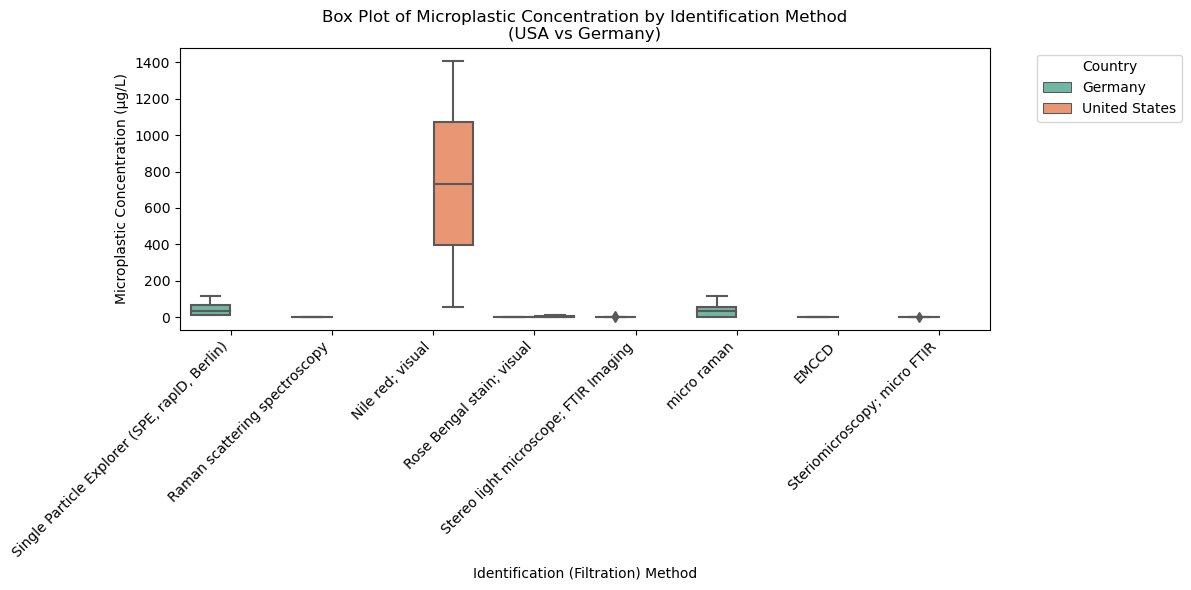

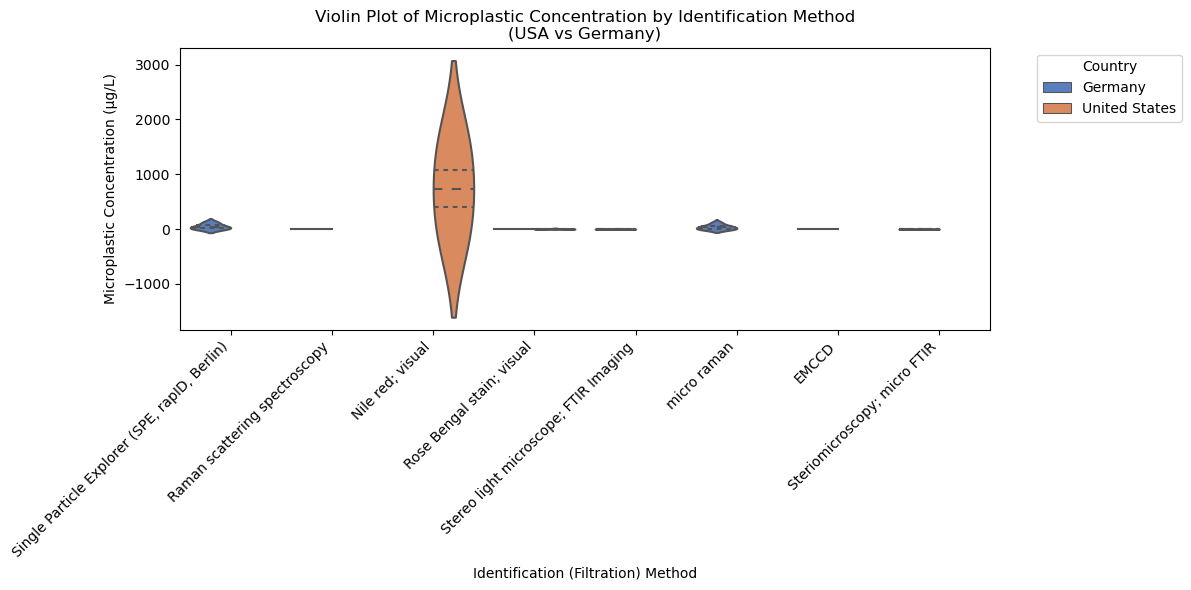

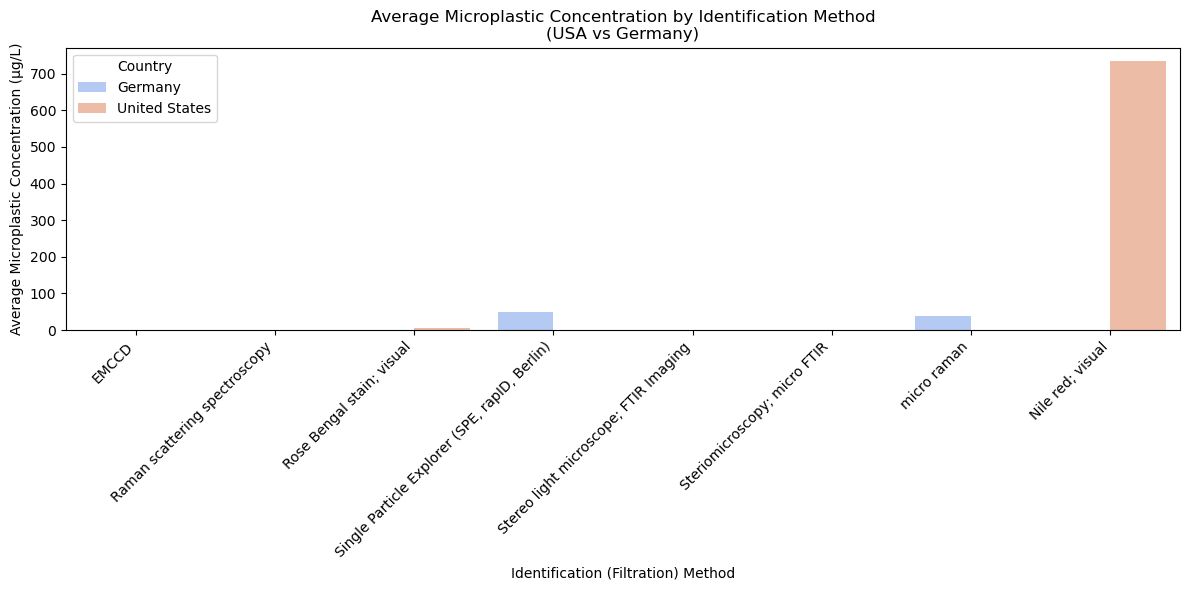

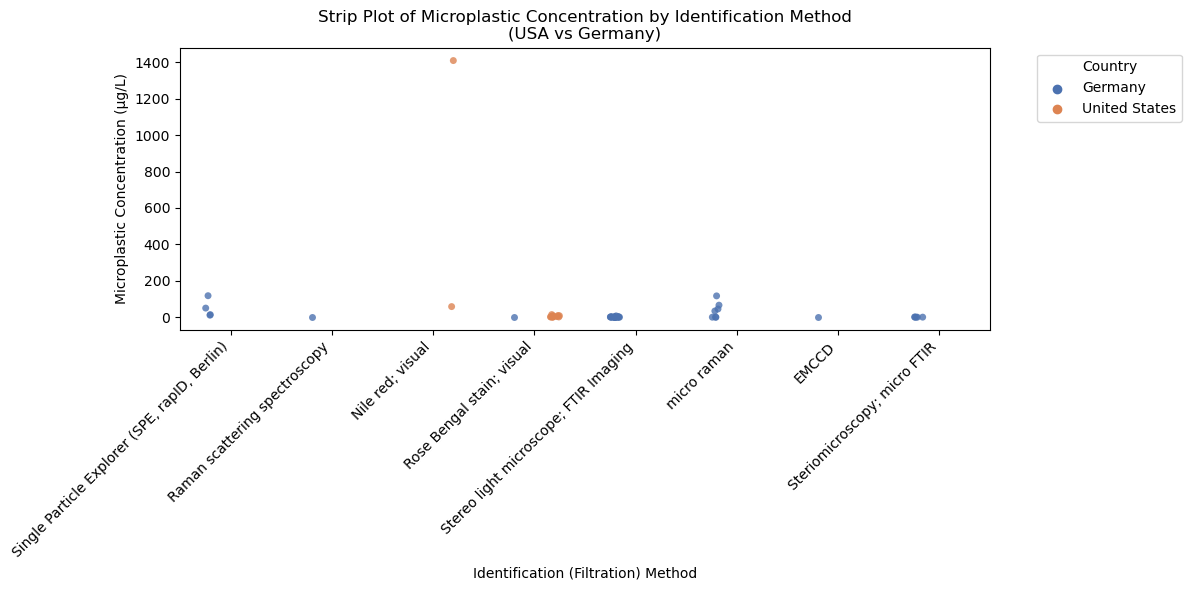

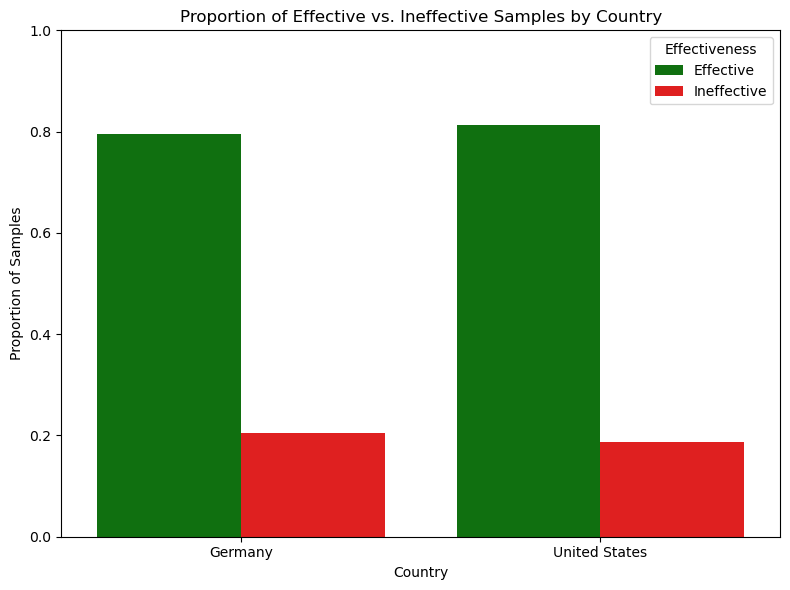

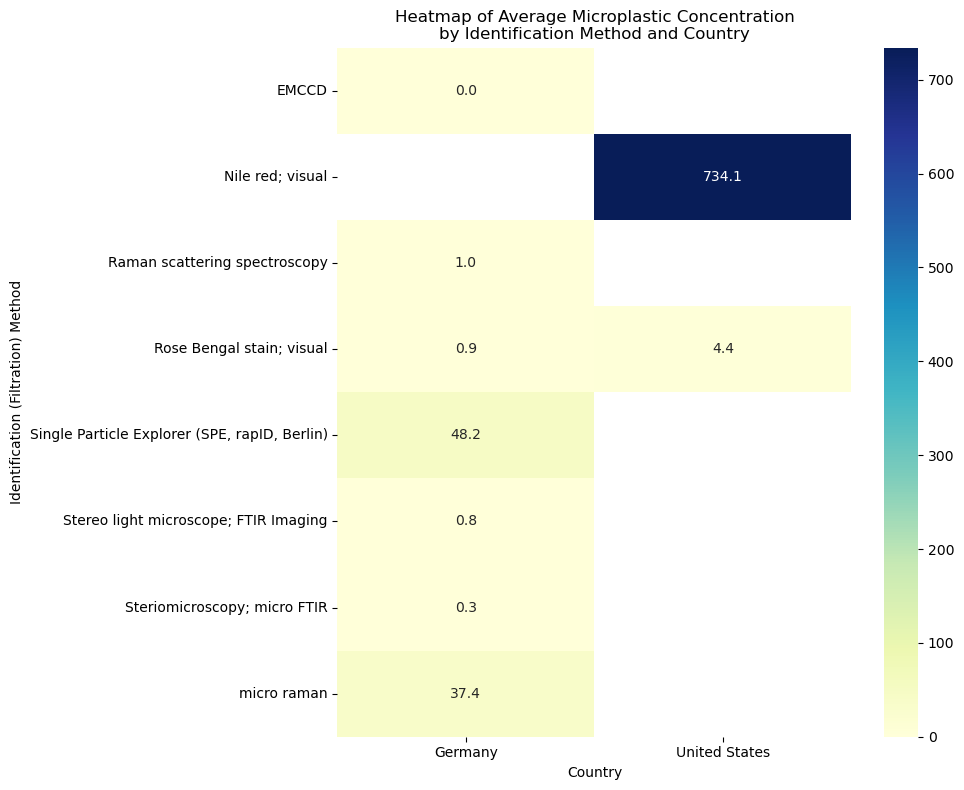

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 0. Data Loading and Cleaning
# -------------------------------

# Load dataset
df = pd.read_csv("Merged_Microplastic_Data.csv")

# Convert 'Concentration' to numeric
df['Concentration'] = pd.to_numeric(df['Concentration'], errors='coerce')

# Drop rows missing key columns
df = df.dropna(subset=['Concentration', 'Countries', 'Microplastic_Identification_Method'])

# (Optional) Remove extremely high concentrations (keep bottom 99%) to reduce skew:
df = df[df['Concentration'] < df['Concentration'].quantile(0.99)]

# Standardize country names (you can adjust these as needed)
df['Countries'] = df['Countries'].str.strip()
df['Countries'] = df['Countries'].replace({
    'USA': 'United States',
    'U.S.A.': 'United States',
    'United States of America': 'United States'
})

# Filter data for Germany and United States only
df_filtered = df[df['Countries'].isin(['Germany', 'United States'])]

# For later plots, remove rows with "Not Provided" in identification method if needed:
df_filtered = df_filtered[df_filtered['Microplastic_Identification_Method'] != "Not Provided"]

# -------------------------------
# 1. Bar Plot: Count of Samples by Identification Method (USA vs Germany)
# -------------------------------
plt.figure(figsize=(12, 6))
sns.countplot(data=df_filtered,
              x='Microplastic_Identification_Method',
              hue='Countries',
              palette='viridis')
plt.title('Count of Samples by Identification Method (USA vs Germany)')
plt.xlabel('Identification (Filtration) Method')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Country')
plt.tight_layout()
plt.show()


# -------------------------------
# 2. Box Plot: Microplastic Concentration by Identification Method (USA vs Germany)
# -------------------------------
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered,
            x='Microplastic_Identification_Method',
            y='Concentration',
            hue='Countries',
            palette='Set2')
plt.title('Box Plot of Microplastic Concentration by Identification Method\n(USA vs Germany)')
plt.xlabel('Identification (Filtration) Method')
plt.ylabel('Microplastic Concentration (µg/L)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# -------------------------------
# 3. Violin Plot: Microplastic Concentration by Identification Method (USA vs Germany)
# -------------------------------
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_filtered,
               x='Microplastic_Identification_Method',
               y='Concentration',
               hue='Countries',
               split=False,  # side-by-side for each country
               dodge=True,
               inner='quartile',
               palette='muted')
plt.title('Violin Plot of Microplastic Concentration by Identification Method\n(USA vs Germany)')
plt.xlabel('Identification (Filtration) Method')
plt.ylabel('Microplastic Concentration (µg/L)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# -------------------------------
# 4. Bar Plot: Average Microplastic Concentration by Identification Method (Grouped by Country)
# -------------------------------
# Calculate average concentration by country and method:
avg_conc = df_filtered.groupby(['Countries', 'Microplastic_Identification_Method'])['Concentration'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=avg_conc, 
            x='Microplastic_Identification_Method', 
            y='Concentration', 
            hue='Countries', 
            palette='coolwarm')
plt.title('Average Microplastic Concentration by Identification Method\n(USA vs Germany)')
plt.xlabel('Identification (Filtration) Method')
plt.ylabel('Average Microplastic Concentration (µg/L)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Country')
plt.tight_layout()
plt.show()


# -------------------------------
# 5. Scatter Plot (Strip Plot): Identification Method vs. Concentration with Jitter
# -------------------------------
plt.figure(figsize=(12, 6))
sns.stripplot(data=df_filtered,
              x='Microplastic_Identification_Method', 
              y='Concentration',
              hue='Countries', 
              jitter=True,
              size=5,
              alpha=0.8,
              dodge=True,
              palette='deep')
plt.title('Strip Plot of Microplastic Concentration by Identification Method\n(USA vs Germany)')
plt.xlabel('Identification (Filtration) Method')
plt.ylabel('Microplastic Concentration (µg/L)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# -------------------------------
# 6. Stacked Bar Chart: Proportion of Effective vs. Ineffective Filters by Country
#    (Using a threshold: samples <10 µg/L are "Effective")
# -------------------------------
# Define threshold for effectiveness
threshold = 10
df_filtered['Effectiveness'] = df_filtered['Concentration'].apply(lambda x: 'Effective' if x < threshold else 'Ineffective')

# Group by Country and Effectiveness
eff_summary = df_filtered.groupby(['Countries', 'Effectiveness']).size().unstack(fill_value=0)

# Convert counts to proportions
eff_prop = eff_summary.div(eff_summary.sum(axis=1), axis=0).reset_index()

# Melt the DataFrame for seaborn
eff_melted = eff_prop.melt(id_vars='Countries', var_name='Effectiveness', value_name='Proportion')

plt.figure(figsize=(8, 6))
sns.barplot(data=eff_melted, x='Countries', y='Proportion', hue='Effectiveness', palette=['green', 'red'])
plt.title('Proportion of Effective vs. Ineffective Samples by Country')
plt.xlabel('Country')
plt.ylabel('Proportion of Samples')
plt.ylim(0, 1)
plt.legend(title='Effectiveness')
plt.tight_layout()
plt.show()


# -------------------------------
# 7. Heatmap (Optional): Average Concentration by Identification Method and Country
# -------------------------------
# Create a pivot table with average concentrations
heatmap_data = df_filtered.pivot_table(index='Microplastic_Identification_Method',
                                       columns='Countries',
                                       values='Concentration',
                                       aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Heatmap of Average Microplastic Concentration\nby Identification Method and Country')
plt.xlabel('Country')
plt.ylabel('Identification (Filtration) Method')
plt.tight_layout()
plt.show()